## Library Imports
All necessary libraries for data handling, modeling, training, and evaluation are imported here.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Load and Explore Data
Load the training and test datasets, check dimensions, visualize class distribution, and preview a sample sequence.


Xtr shape: (2000, 2)
Ytr shape: (2000, 2)
Xte shape: (1000, 2)

Sample sequence from Xtr:
0


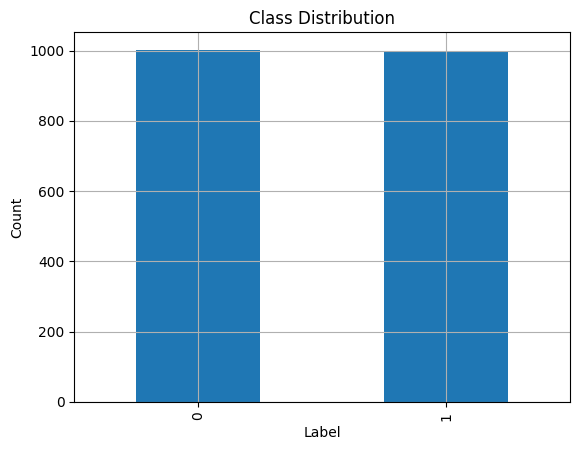

In [6]:
data_path = "/content/df"
Xtr = pd.read_csv(os.path.join(data_path, "Xtr.csv"))
Xte = pd.read_csv(os.path.join(data_path, "Xte.csv"))
Ytr = pd.read_csv(os.path.join(data_path, "Ytr.csv"))
Xtr_mat = pd.read_csv(os.path.join(data_path, "Xtr_mat100.csv"), sep='\s+', header=None)
Xte_mat = pd.read_csv(os.path.join(data_path, "Xte_mat100.csv"), sep='\s+', header=None)

# quick data check
print("Xtr shape:", Xtr.shape)
print("Ytr shape:", Ytr.shape)
print("Xte shape:", Xte.shape)

print("\nSample sequence from Xtr:")
print(Xtr.iloc[0, 0])

# Check class distribution
Ytr['Bound'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid()
plt.show()

## One-Hot Encoding of DNA Sequences
Transform DNA sequences into one-hot encoded tensors and prepare cluster-based features for training and testing.


In [8]:
def one_hot_encode_seq(seq, maxlen=101):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot = np.zeros((4, maxlen), dtype=np.float32)
    for i, char in enumerate(seq):
        if char in mapping:
            one_hot[mapping[char], i] = 1.0
    return one_hot

X_seq = np.stack([one_hot_encode_seq(seq) for seq in Xtr["seq"]])
X_test_seq = np.stack([one_hot_encode_seq(seq) for seq in Xte["seq"]])

X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_tensor = torch.tensor(Ytr["Bound"].values, dtype=torch.float32)

X_cluster_tensor = torch.tensor(Xtr_mat.values, dtype=torch.float32)
X_test_cluster_tensor = torch.tensor(Xte_mat.values, dtype=torch.float32)

print("Data loaded and encoded.")
print("X_seq shape:", X_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print(f"X_seq_tensor shape: {X_seq_tensor.shape}")
print(f"X_cluster_tensor shape: {X_cluster_tensor.shape}")

Data loaded and encoded.
X_seq shape: (2000, 4, 101)
X_test_seq shape: (1000, 4, 101)
X_seq_tensor shape: torch.Size([2000, 4, 101])
X_cluster_tensor shape: torch.Size([2000, 100])


## Model Architecture Definitions


In [22]:
# Define models
class CNNKMeansFusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=9, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=15, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        self.mlp = nn.Sequential(
            nn.Linear(256 + 50, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, x_clust):
        x_cnn = self.cnn(x_seq)
        x_concat = torch.cat([x_cnn, x_clust], dim=1)
        return self.mlp(x_concat)

class CNNOnlyV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv1d(4, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Conv1d(256, 256, kernel_size=15, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_block(x)
        return self.classifier(x)

# Instantiate models
model1 = CNNKMeansFusion()
model2 = CNNOnlyV2()

## Data Preprocessing & Custom Dataset Definition


In [15]:
# truncate first
X_cluster_tensor = X_cluster_tensor[:, :50]
X_test_cluster_tensor = X_test_cluster_tensor[:, :50]

# then normalize
scaler = StandardScaler()
X_cluster = scaler.fit_transform(X_cluster_tensor)
X_test_cluster = scaler.transform(X_test_cluster_tensor)

X_cluster_tensor = torch.tensor(X_cluster, dtype=torch.float32)
X_test_cluster_tensor = torch.tensor(X_test_cluster, dtype=torch.float32)

# train/validation split
X_seq_train, X_seq_val, X_clust_train, X_clust_val, y_train, y_val = train_test_split(
    X_seq_tensor, X_cluster_tensor, y_tensor, test_size=0.2, random_state=42)

## Custom dataset for dual-input (sequence + cluster) models
class DualInputDataset(Dataset):
    def __init__(self, seq_tensor, clust_tensor, labels):
        self.seq = seq_tensor
        self.clust = clust_tensor
        self.labels = labels

    def __getitem__(self, idx):
        return self.seq[idx], self.clust[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

# DataLoaders
train_dataset = DualInputDataset(X_seq_train, X_clust_train, y_train)
val_dataset = DualInputDataset(X_seq_val, X_clust_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Model Training: Loss, Accuracy & Training Loop


In [13]:
# Define loss and accuracy
def compute_accuracy(preds, labels):
    preds = (preds >= 0.5).float()
    correct = (preds == labels).float().sum()
    return correct / len(labels)

# Training loop function
def train_model(model, optimizer, train_loader, val_loader, mode="cnn_kmeans", epochs=50):
    loss_fn = nn.BCELoss()
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, xc, yb in train_loader:
            if mode == "cnn_only":
                preds = model(xb).squeeze()
            elif mode == "mlp":
                preds = model(xc).squeeze()
            else:  # cnn_kmeans
                preds = model(xb, xc).squeeze()

            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for xb, xc, yb in val_loader:
                if mode == "cnn_only":
                    preds = model(xb).squeeze()
                elif mode == "mlp":
                    preds = model(xc).squeeze()
                else:
                    preds = model(xb, xc).squeeze()
                val_preds.append(preds)
                val_targets.append(yb)

        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)
        val_acc = ((val_preds >= 0.5).float() == val_targets).float().mean().item()
        avg_loss = total_loss / len(train_loader)

        # Print output for each epoch
        print(f"[{mode}] Epoch {epoch+1:02d} - Loss: {avg_loss:.4f} - Val Accuracy: {val_acc:.4f} - Best: {max(val_acc, best_acc):.4f}", flush=True)

        best_acc = max(best_acc, val_acc)

# Define optimizers
opt1 = torch.optim.Adam(model1.parameters(), lr=0.002)  # CNN+KMeans
opt2 = torch.optim.Adam(model2.parameters(), lr=0.003)  # CNNOnly

# Train both models
print("Training CNN+KMeans model...", flush=True)
train_model(model1, opt1, train_loader, val_loader, mode="cnn_kmeans", epochs=50)

print("\nTraining CNNOnly model...", flush=True)
train_model(model2, opt2, train_loader, val_loader, mode="cnn_only", epochs=50)

Training CNN+KMeans model...
[cnn_kmeans] Epoch 01 - Loss: 0.7131 - Val Accuracy: 0.4775 - Best: 0.4775
[cnn_kmeans] Epoch 02 - Loss: 0.6503 - Val Accuracy: 0.6650 - Best: 0.6650
[cnn_kmeans] Epoch 03 - Loss: 0.5554 - Val Accuracy: 0.6975 - Best: 0.6975
[cnn_kmeans] Epoch 04 - Loss: 0.4744 - Val Accuracy: 0.6700 - Best: 0.6975
[cnn_kmeans] Epoch 05 - Loss: 0.4069 - Val Accuracy: 0.7075 - Best: 0.7075
[cnn_kmeans] Epoch 06 - Loss: 0.3123 - Val Accuracy: 0.7000 - Best: 0.7075
[cnn_kmeans] Epoch 07 - Loss: 0.1817 - Val Accuracy: 0.6350 - Best: 0.7075
[cnn_kmeans] Epoch 08 - Loss: 0.1448 - Val Accuracy: 0.6725 - Best: 0.7075
[cnn_kmeans] Epoch 09 - Loss: 0.1431 - Val Accuracy: 0.6900 - Best: 0.7075
[cnn_kmeans] Epoch 10 - Loss: 0.2202 - Val Accuracy: 0.6800 - Best: 0.7075
[cnn_kmeans] Epoch 11 - Loss: 0.1267 - Val Accuracy: 0.6975 - Best: 0.7075
[cnn_kmeans] Epoch 12 - Loss: 0.0718 - Val Accuracy: 0.6950 - Best: 0.7075
[cnn_kmeans] Epoch 13 - Loss: 0.0827 - Val Accuracy: 0.6675 - Best: 0.7

## Generate final predictions and create submission file


This section combines the predictions from both trained models using a weighted average, then saves the final results in the Kaggle submission format.


In [24]:
# Generate predictions from both models
with torch.no_grad():
    preds1 = model1(X_test_seq_tensor, X_test_cluster_tensor).squeeze()
    preds2 = model2(X_test_seq_tensor).squeeze()

    alpha = 0.715
    final_probs = (alpha * preds1 + (1 - alpha) * preds2).cpu().numpy()
    final_preds = (final_probs >= 0.5).astype(int)

# save the predictions into a CSV file
submission_name = "Submission.csv"
with open(submission_name, "w") as f:
    f.write("Id,Bound\n")
    for i, p in enumerate(final_preds):
        f.write(f"{i},{p}\n")

print(f"Submission file '{submission_name}' generated successfully.")


Submission file 'Submission.csv' generated successfully.
